In this notebook we prepare the plots for virtual telescope for the final presentation

In [95]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from sdo.pytorch_utilities import init_gpu, set_seed
from sdo.models.vt_encoder_decoder import VT_EncoderDecoder
from sdo.models.vt_basic_encoder import VT_BasicEncoder
from sdo.models.vt_basic_encoder import VT_BasicEncoder
from sdo.models.unet_generator import UnetGenerator

from sdo.datasets.virtual_telescope_sdo_dataset import VirtualTelescopeSDO_Dataset

from sdo.viz.plot_vt_outputs import plot_difference, plot_2d_hist
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sunpy.map

%matplotlib inline

In [14]:
experiment_name = 'v_experiment_10'
epoch = '0600'
vt_dir ='/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/experiments_results_vt/'
experiment = '{}/{}_{}_model.pth'.format(experiment_name, epoch, experiment_name)
path_model = os.path.join(vt_dir, experiment)
plot_dir = '/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/results/plots/'

## Load the model

In [10]:
device = init_gpu()
set_seed()

In [15]:
scaled_height = 128
scaled_width = 128
channels = ['0094', '0171', '0193', '0211']
num_channels = len(channels) - 1

model = UnetGenerator(input_shape=[num_channels, scaled_height, scaled_width])
model.cuda(device)
model.eval()


------Initiating U-Net------



UnetGenerator(
  (down_1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool_3): MaxPool2d(kernel_size=

In [16]:
state_dict = torch.load(path_model)
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Load one batch

In [17]:
batch_size_test = 5
tolerance = 0.05

# in the model above we trained on "0094","0171","0193" and predicted "0211"
test_dataset = VirtualTelescopeSDO_Dataset(num_channels+1,
                                 instr=["AIA"] * (num_channels+1),
                                 channels=[
                                     "0094",
                                     "0171",
                                     "0193",
                                     "0211"],
                                 yr_range=[2016, 2016],
                                 mnt_step=1,
                                 day_step=1,
                                 h_step=6,
                                 min_step=60,
                                 resolution=512,
                                 subsample=4,
                                 normalization=0,
                                 scaling=True,
                                 shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test)

In [18]:
# extract the first batch
examples = enumerate(test_loader)
batch_idx, (input_data, gt_output, _) = next(examples)

In [19]:
all_input = []
all_gt_output = []
all_output = []

input_data = input_data.to(device)
gt_output = gt_output.to(device)
output = model(input_data)

input_data = input_data.cpu().detach().numpy()
output = output.cpu().detach().numpy()
gt_output = gt_output.cpu().detach().numpy()

# Prediction - Channels #

In [20]:
gt_output_t = gt_output[0,0,:,:]
output_t = output[0,0,:,:]
input_data_t = input_data[0,:,:,:]

In [121]:
def plot_difference_input_gt(img_gt, input_channels, channels, img_file=None):
    
    channels_mean =np.mean(input_channels, axis=0)

    fig, axs = plt.subplots(1, 4, figsize=(18, 5), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    GT = channels[-1]
    for i, ch in enumerate(channels[:-1]):
        im = axs[i].imshow((input_channels[i,:,:] - img_gt),cmap='seismic', vmin=-1, vmax=1, origin='lower')
        axs[i].set_title('AIA {} - AIA {}'.format(ch, GT))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
        
    im = axs[i+1].imshow((channels_mean - img_gt),cmap='seismic', vmin=-1, vmax=1, origin='lower')
    axs[i+1].set_title('Mean inputs - AIA {}'.format(GT))
    axs[i+1].get_xaxis().set_visible(False)
    axs[i+1].get_yaxis().set_visible(False)
    
    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # distance from left border, space from bottom, bar width, space from top
    cbar_ax = fig.add_axes([0.82, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    
    if img_file:
        plt.savefig(img_file, bbox_inches='tight')
        plt.close()

In [92]:
img_file = 'input_GT_{}_no_axes.png'.format(experiment_name)
img_file = plot_dir + img_file
plot_difference_input_gt(gt_output_t, input_data_t, channels, img_file=img_file)

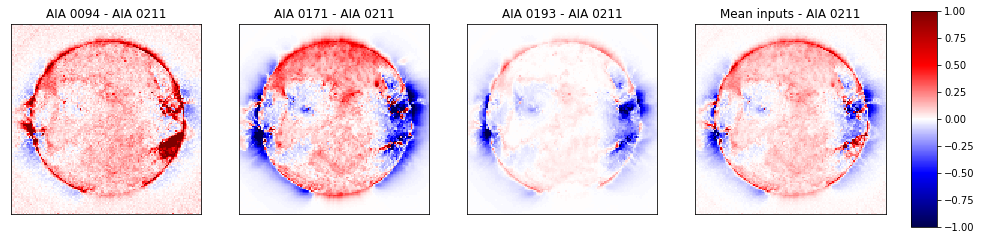

In [122]:
plot_difference_input_gt(gt_output_t, input_data_t, channels)

In [125]:
def plot_difference_pred_gt(img_gt, img_pred, channel, img_file=None):
    fig, axs = plt.subplots(1, 3, figsize=(16, 16), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    im = axs[0].imshow(img_gt, origin='lower', vmin=0, vmax=2, cmap='hot')
    axs[0].set_title('Real AIA {}'.format(channel))
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)
    
    im = axs[1].imshow((img_pred - img_gt), cmap='seismic', vmin=-1, vmax=1, origin='lower')
    axs[1].set_title('Real - Generated AIA {}'.format(channel))
    axs[1].get_xaxis().set_visible(False)
    axs[1].get_yaxis().set_visible(False)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
        
    im = axs[2].imshow(img_pred, origin='lower', vmin=0, vmax=2, cmap='hot')
    axs[2].set_title('Generated AIA {}'.format(channel))
    axs[2].get_xaxis().set_visible(False)
    axs[2].get_yaxis().set_visible(False)
    
    if img_file:
        plt.savefig(img_file, bbox_inches='tight')
        plt.close()

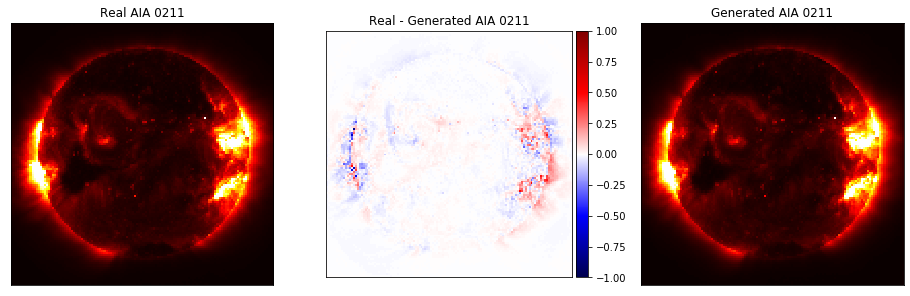

In [126]:
# units of 100 DN/s/pixel
plot_difference_pred_gt(gt_output_t, output_t, channels[-1])

In [127]:
img_file = 'pred_GT_{}_no_axes.png'.format(experiment_name)
img_file = plot_dir + img_file
plot_difference_pred_gt(gt_output_t, output_t, channels[-1], img_file=img_file)

In [86]:
def plot_original_input(img_gt, input_channels, channels, img_file=None):
    fig, axs = plt.subplots(1, 4, figsize=(18, 5), facecolor='w', edgecolor='k')
    
    axs = axs.ravel()
    for i, ch in enumerate(channels[:-1]):
        im = axs[i].imshow(input_channels[i,:,:], cmap='hot', vmin=0, vmax=2, origin='lower')
        axs[i].set_title('AIA {}'.format(ch))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    im = axs[i+1].imshow(img_gt, cmap='hot', vmin=0, vmax=2, origin='lower')
    axs[i+1].set_title('AIA {}'.format(channels[-1]))    
    axs[i+1].get_xaxis().set_visible(False)
    axs[i+1].get_yaxis().set_visible(False)
    
    if img_file:
        plt.savefig(img_file, bbox_inches='tight')
        plt.close()

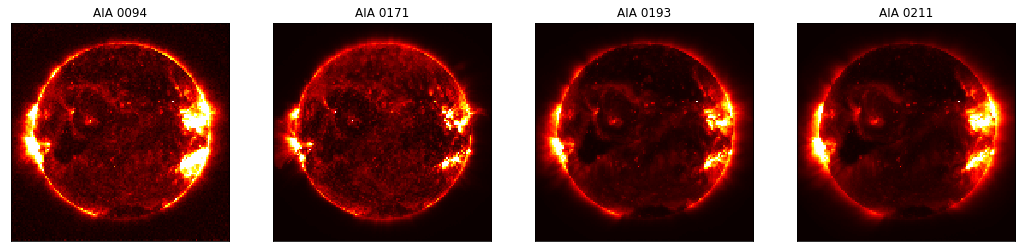

In [87]:
plot_original_input(gt_output_t, input_data_t, channels)

In [79]:
def plot_original_input_diff_cmap(img_gt, input_channels, channels, img_file=None):
    fig, axs = plt.subplots(1, 4, figsize=(18, 5), facecolor='w', edgecolor='k')
    colors = ['YlGn', 'RdPu', 'BuPu', 'Reds']
    axs = axs.ravel()
    for i, ch in enumerate(channels[:-1]):
        im = axs[i].imshow(input_channels[i,:,:], cmap=colors[i], vmin=0, vmax=0.8, origin='lower')
        axs[i].set_title('AIA {}'.format(ch))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    im = axs[i+1].imshow(img_gt, cmap=colors[i+1], vmin=0, vmax=0.8, origin='lower')
    axs[i+1].set_title('AIA {}'.format(channels[-1]))
    axs[i+1].get_xaxis().set_visible(False)
    axs[i+1].get_yaxis().set_visible(False)
    
    if img_file:
        plt.savefig(img_file, bbox_inches='tight')
        plt.close()

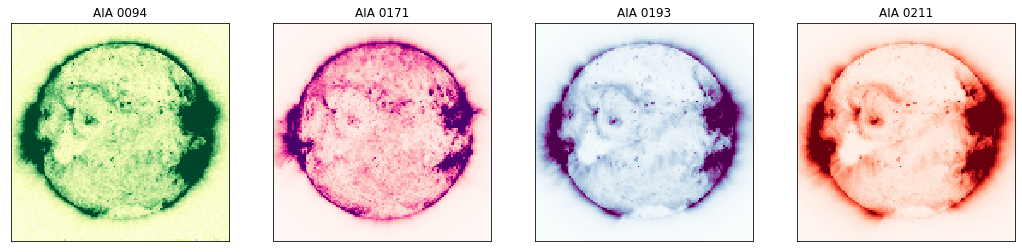

In [80]:
plot_original_input_diff_cmap(gt_output_t, input_data_t, channels)

In [111]:
img_file = 'original_images_color_{}_no_axes.png'.format(experiment_name)
img_file = plot_dir + img_file
plot_original_input_diff_cmap(gt_output_t, input_data_t, channels, img_file=img_file)

In [28]:
img_file = 'original_images_{}.png'.format(experiment_name)
img_file = plot_dir + img_file
plot_original_input(gt_output_t, input_data_t, channels, img_file=img_file)

In [34]:
img_file = '2dhist_{}.png'.format(experiment_name)
img_file = plot_dir + img_file
plot_2d_hist(gt_output_t, output_t, img_file, bins=100)

/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/expanding-sdo-capabilities/src/sdo/viz/plot_vt_outputs.py:53: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(H/1.), origin='lower',


In [99]:
aiamap = sunpy.map.Map(input_data_t[0,:,:])

IndexError: list index out of range